# A000682 Exponential BucketsTotal Adaptation Analysis

Notebook Purpose
-----------------
Test the hypothesis that during the exponential growth phase the A000682 bucketsTotal(n,k) may reuse the A005316 parity-based exponential formulas with systematic, multiplicative adjustments derived from initial condition structure and simple functions of n and k.

We proceed through: data validation, reproduction of A005316 baseline, residual diagnostics, feature engineering, linear / regularized / nonlinear modeling, parity subclass analysis, power-law grid search, closed-form adjustment proposal, validation, and packaging of a predictive function.

Assumptions
-----------
- Dataset already filtered to exponential growth region.
- Column `A005316` is baseline prediction using A005316 formula applied naïvely to A000682 rows.
- We restrict analysis to n≤ current data (n<50).
- Initial conditions differ chiefly in the count and bit pattern span of starting curveLocations.

Conventions
-----------
- Descriptive camelCase identifiers.
- No lambda functions.
- Single return per helper function.
- Deterministic execution order.


In [ ]:
# Section 1: Load Dependencies & Configure Environment
# Kernel expected: .vanalysis (pre-provisioned environment)
# pyright: basic

from pathlib import Path
import json
import math
import matplotlib.pyplot as pyplot
import numpy
import pandas
import seaborn as seaborn
import statistics

# Try optional modeling libraries
try:
    import statsmodels.api as statsmodels_api  # noqa: F401
    import statsmodels.formula.api as statsmodels_formula  # noqa: F401
    hasStatsmodels = True
except Exception:  # pragma: no cover
    hasStatsmodels = False

try:
    from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    hasSklearn = True
except Exception:  # pragma: no cover
    hasSklearn = False

numpy.set_printoptions(suppress=True, linewidth=140)
seaborn.set_theme(context='notebook', style='whitegrid')
randomSeedFixed = 314159
numpy.random.seed(randomSeedFixed)

# Resolve data path relative to notebook working directory (assumed reference directory)
pathData = Path('A000682expAnalysis.csv').resolve()
print(f'Reading dataset from: {pathData}')

In [ ]:
# Section 2: Load A000682 Exponential Growth Dataset

columnDtypes: dict[str, str] = {
    'n': 'int64', 'k': 'int64', 'buckets': 'int64', 'nLess_k': 'int64', 'nLess_kHalf': 'int64',
    'nLess_kOdd': 'boolean', 'expGrowth': 'boolean', 'kOdd': 'boolean', 'x': 'float64', 'offset': 'float64', 'A005316': 'float64'
}

dataframeBuckets = pandas.read_csv(pathData, dtype=columnDtypes)
print('Rows loaded:', len(dataframeBuckets.index))
print('Columns:', list(dataframeBuckets.columns))
assert dataframeBuckets['expGrowth'].all(), 'Dataset must represent exponential phase only.'

# Basic stats
print(dataframeBuckets.describe(include='all').transpose()[['mean','std','min','max']])

dataframeBuckets.head(10)

In [ ]:
# Section 3: Load A005316 Coefficients & Define Base Formula (tolerance adjusted for CSV rounding)

xCommon = 1.57
coefficientsParity: dict[tuple[bool, bool], float] = {
    (False, True): 0.834,      # k even, nLess_k odd
    (False, False): 1.5803,    # k even, nLess_k even
    (True, True): 1.556,       # k odd, nLess_k odd
    (True, False): 1.8047      # k odd, nLess_k even
}

def computeXInstant(nLess_kValue: int) -> int:
    xInstantValue: int = nLess_kValue // 2
    if nLess_kValue % 2 == 1:
        xInstantValue += 1
    return xInstantValue

def predictA005316Like(nLess_kValue: int, kOddValue: bool, nLess_kOddValue: bool) -> float:
    coefficient = coefficientsParity[(kOddValue, nLess_kOddValue)]
    xInstantValue = computeXInstant(nLess_kValue)
    prediction = coefficient * math.exp(xCommon * xInstantValue)
    return prediction

def recomputeBaselineVectorized(dataframeInput: pandas.DataFrame) -> numpy.ndarray:
    listPredictions: list[float] = []
    for record in dataframeInput.itertuples(index=False):
        listPredictions.append(
            predictA005316Like(getattr(record, 'nLess_k'), bool(getattr(record, 'kOdd')), bool(getattr(record, 'nLess_kOdd')))
        )
    return numpy.array(listPredictions, dtype=float)

recomputedBaseline = recomputeBaselineVectorized(dataframeBuckets)

differenceBaseline = numpy.abs(recomputedBaseline - dataframeBuckets['A005316'].to_numpy())
maxDifference = float(differenceBaseline.max())
print('Max absolute diff vs provided A005316 column:', maxDifference)
assert maxDifference < 5e-3, f'Provided A005316 column mismatch (diff={maxDifference}).'

# Store for future use
dataframeBuckets['baselineA005316'] = recomputedBaseline

In [ ]:
# Section 4: Verify Exponential Growth Assumption

logBuckets = numpy.log(dataframeBuckets['buckets'])
dataframeBuckets['xInstant'] = dataframeBuckets['nLess_k'].apply(computeXInstant)

resultsParityGrowth: list[dict[str, float | str]] = []
for kOddValue in (False, True):
    for nLessOddValue in (False, True):
        mask = (dataframeBuckets['kOdd'] == kOddValue) & (dataframeBuckets['nLess_kOdd'] == nLessOddValue)
        dataframeSubset = dataframeBuckets.loc[mask]
        if len(dataframeSubset.index) < 3:
            continue
        xVector = dataframeSubset['xInstant'].to_numpy().reshape(-1, 1)
        yVector = numpy.log(dataframeSubset['buckets']).to_numpy()
        if hasSklearn:
            modelLocal = LinearRegression()
            modelLocal.fit(xVector, yVector)
            slope = float(modelLocal.coef_[0])
            intercept = float(modelLocal.intercept_)
            r2 = float(modelLocal.score(xVector, yVector))
        else:
            slope, intercept = numpy.polyfit(dataframeSubset['xInstant'], numpy.log(dataframeSubset['buckets']), 1)
            yHat = intercept + slope * dataframeSubset['xInstant']
            ssRes = float(numpy.square(numpy.log(dataframeSubset['buckets']) - yHat).sum())
            ssTot = float(numpy.square(numpy.log(dataframeSubset['buckets']) - numpy.log(dataframeSubset['buckets']).mean()).sum())
            r2 = 1.0 - ssRes / ssTot
        resultsParityGrowth.append({
            'parityClass': f"kOdd={kOddValue},nLessOdd={nLessOddValue}",
            'slope': slope,
            'intercept': intercept,
            'r2': r2,
            'rows': len(dataframeSubset.index)
        })

pandas.DataFrame(resultsParityGrowth)

In [ ]:
# Section 5: Compute Initial Conditions Features

# Manually embed dictionary_nToDictionaryCurveLocations (compressed summary) by counting entries.
from mapFolding.reference.A000682facts import dictionary_nToDictionaryCurveLocations as dictionary_nToDictionaryCurveLocations_A000682

def deriveInitialConditionStats(dictionaryCurveLocations: dict[int, int]) -> tuple[int, int, int]:
    countEntries: int = len(dictionaryCurveLocations)
    sumDistinctCrossings: int = int(sum(dictionaryCurveLocations.values()))
    maximumBitWidth: int = max(dictionaryCurveLocations.keys()).bit_length()
    return countEntries, sumDistinctCrossings, maximumBitWidth

listRecords: list[dict[str, int]] = []
for nValue, dictLocations in dictionary_nToDictionaryCurveLocations_A000682.items():
    countEntries, sumDistinctCrossings, maximumBitWidth = deriveInitialConditionStats(dictLocations)
    listRecords.append({
        'n': nValue,
        'initialCountCurveLocations': countEntries,
        'initialSumDistinctCrossings': sumDistinctCrossings,
        'initialMaximumBitWidth': maximumBitWidth
    })

dataframeInitial = pandas.DataFrame(listRecords)
# Filter to n values present in exponential dataset
presentN = dataframeBuckets['n'].unique()
dataframeInitial = dataframeInitial.loc[dataframeInitial['n'].isin(presentN)]

print('Initial conditions stats rows:', len(dataframeInitial.index))
dataframeInitial.head()

In [ ]:
# Section 6: Merge Dataset With Initial Conditions Stats

dataframeBuckets = dataframeBuckets.merge(dataframeInitial, on='n', how='left')
assert dataframeBuckets['initialCountCurveLocations'].notna().all(), 'Missing initial condition features.'

correlationTargets = ['buckets','baselineA005316']
featureCandidates = ['initialCountCurveLocations','initialSumDistinctCrossings','initialMaximumBitWidth','n','k','nLess_k','xInstant']
correlationMatrix = dataframeBuckets[correlationTargets + featureCandidates].corr(numeric_only=True)
correlationMatrix

In [ ]:
# Section 7: Log Residuals vs Baseline (tolerance aligned with earlier cell)

maxDifferenceProvided = float(numpy.abs(dataframeBuckets['A005316'] - dataframeBuckets['baselineA005316']).max())
print('Consistency A005316 baseline vs recomputed:', maxDifferenceProvided)
assert maxDifferenceProvided < 5e-3, 'Baseline mismatch exceeds accepted CSV rounding tolerance.'

dataframeBuckets['residualRatio'] = dataframeBuckets['buckets'] / dataframeBuckets['baselineA005316']
dataframeBuckets['residualLog'] = numpy.log(dataframeBuckets['residualRatio'])

print('Residual ratio stats:')
print(dataframeBuckets['residualRatio'].describe())
print('\nResidual log stats:')
print(dataframeBuckets['residualLog'].describe())

In [ ]:
# Section 8: Residual Analysis of Base Formula

dataframeBuckets['residualAbsolute'] = dataframeBuckets['buckets'] - dataframeBuckets['baselineA005316']
dataframeBuckets['residualRatio'] = dataframeBuckets['buckets'] / dataframeBuckets['baselineA005316']
dataframeBuckets['residualLog'] = numpy.log(dataframeBuckets['buckets']) - numpy.log(dataframeBuckets['baselineA005316'])

summaryResiduals = dataframeBuckets[['residualAbsolute','residualRatio','residualLog']].describe()
print(summaryResiduals)

groupedParityResidual = dataframeBuckets.groupby(['kOdd','nLess_kOdd'])['residualLog'].agg(['mean','std','count']).reset_index()
print(groupedParityResidual)

dataframeBuckets[['n','k','residualRatio','residualLog']].head(10)

In [ ]:
# Section 9: Feature Engineering for Adjustment Terms

# Additional engineered features

dataframeBuckets['logBuckets'] = numpy.log(dataframeBuckets['buckets'])
dataframeBuckets['logBaseline'] = numpy.log(dataframeBuckets['baselineA005316'])
dataframeBuckets['logInitialCount'] = numpy.log(dataframeBuckets['initialCountCurveLocations'])
dataframeBuckets['inverseInitialCount'] = 1.0 / dataframeBuckets['initialCountCurveLocations']
dataframeBuckets['kOverN'] = dataframeBuckets['k'] / dataframeBuckets['n']
dataframeBuckets['nLess_kOverN'] = dataframeBuckets['nLess_k'] / dataframeBuckets['n']
dataframeBuckets['kTimesNLess_k'] = dataframeBuckets['k'] * dataframeBuckets['nLess_k']
dataframeBuckets['kTimesLogN'] = dataframeBuckets['k'] * numpy.log(dataframeBuckets['n'])
dataframeBuckets['xInstantTimesLogInitial'] = dataframeBuckets['xInstant'] * dataframeBuckets['logInitialCount']

for parityColumn in ['kOdd','nLess_kOdd']:
    dataframeBuckets[parityColumn] = dataframeBuckets[parityColumn].astype(int)

dataframeBuckets['parityInteraction'] = dataframeBuckets['kOdd'] * dataframeBuckets['nLess_kOdd']

featureColumnsForModel = [
    'logBaseline','n','k','nLess_k','xInstant','initialCountCurveLocations','initialMaximumBitWidth',
    'logInitialCount','inverseInitialCount','kOverN','nLess_kOverN','kTimesNLess_k','kTimesLogN','xInstantTimesLogInitial','kOdd','nLess_kOdd','parityInteraction'
]

dataframeBuckets[featureColumnsForModel].head(10)

In [ ]:
# Section 10: Fit Linear Model on Log-Residuals (logBuckets ~ logBaseline + adjustments)

if hasSklearn:
    targetVector = dataframeBuckets['logBuckets'].to_numpy()
    matrixFeatures = dataframeBuckets[featureColumnsForModel].to_numpy()
    linearModel = LinearRegression()
    linearModel.fit(matrixFeatures, targetVector)
    predictionsLog = linearModel.predict(matrixFeatures)
    r2Linear = r2_score(targetVector, predictionsLog)
    maeLinear = mean_absolute_error(targetVector, predictionsLog)
    print('Linear model (sklearn) R2:', r2Linear, 'MAE(log):', maeLinear)
    coefficientsLinear = pandas.Series(linearModel.coef_, index=featureColumnsForModel)
    dataframeCoefficientsLinear = coefficientsLinear.sort_values(ascending=False).to_frame(name='coefficient')
else:
    formula = 'logBuckets ~ ' + ' + '.join(featureColumnsForModel)
    if hasStatsmodels:
        modelStats = statsmodels_formula.ols(formula=formula, data=dataframeBuckets).fit()
        print(modelStats.summary())
        dataframeCoefficientsLinear = modelStats.params.to_frame(name='coefficient')
    else:
        dataframeCoefficientsLinear = pandas.DataFrame({'coefficient': []})

dataframeCoefficientsLinear.head(20)

In [ ]:
# Section 11: Regularized Models (Ridge, Lasso)

deviceNote = 'Running regularized regression models'
print(deviceNote)

if hasSklearn:
    scaler = StandardScaler()
    # Removed deprecated/unsupported parameter store_cv_values for current sklearn version
    ridgeModel = RidgeCV(alphas=(0.1, 1.0, 10.0))
    pipelineRidge = Pipeline(steps=[('scale', scaler), ('ridge', ridgeModel)])
    pipelineRidge.fit(matrixFeatures, targetVector)
    predictionsRidge = pipelineRidge.predict(matrixFeatures)
    r2Ridge = r2_score(targetVector, predictionsRidge)
    maeRidge = mean_absolute_error(targetVector, predictionsRidge)
    print(f'RidgeCV R2: {r2Ridge:.6f} MAE(log): {maeRidge:.6f} alphaSelected: {pipelineRidge.named_steps["ridge"].alpha_}')

    lassoModel = LassoCV(alphas=None, cv=5, max_iter=5000, n_jobs=None)
    pipelineLasso = Pipeline(steps=[('scale', scaler), ('lasso', lassoModel)])
    pipelineLasso.fit(matrixFeatures, targetVector)
    predictionsLasso = pipelineLasso.predict(matrixFeatures)
    r2Lasso = r2_score(targetVector, predictionsLasso)
    maeLasso = mean_absolute_error(targetVector, predictionsLasso)
    print(f'LassoCV R2: {r2Lasso:.6f} MAE(log): {maeLasso:.6f} alphaSelected: {pipelineLasso.named_steps["lasso"].alpha_}')
else:
    print('sklearn not available, skipping regularized models')

In [ ]:
# Section 12: Evaluate Parity Subseries Separately (OLS per parity on log residual)

paritySubseriesResults: list[dict[str, float | str]] = []
for kOddValue in (0,1):
    for nLessOddValue in (0,1):
        mask = (dataframeBuckets['kOdd'] == kOddValue) & (dataframeBuckets['nLess_kOdd'] == nLessOddValue)
        dataframeSubset = dataframeBuckets.loc[mask]
        if len(dataframeSubset.index) < 8:
            continue
        featuresSubset = dataframeSubset[featureColumnsForModel].to_numpy()
        targetSubset = dataframeSubset['logBuckets'].to_numpy()
        if hasSklearn:
            modelLocal = LinearRegression()
            modelLocal.fit(featuresSubset, targetSubset)
            predictionLocal = modelLocal.predict(featuresSubset)
            r2Local = r2_score(targetSubset, predictionLocal)
            maeLocal = mean_absolute_error(targetSubset, predictionLocal)
        else:
            r2Local = float('nan')
            maeLocal = float('nan')
        paritySubseriesResults.append({
            'kOdd': kOddValue,
            'nLess_kOdd': nLessOddValue,
            'rows': len(dataframeSubset.index),
            'r2': r2Local,
            'maeLog': maeLocal
        })

pandas.DataFrame(paritySubseriesResults)

In [ ]:
# Section 13: Nonlinear Adjustment Exploration (power forms)

# Explore candidate multiplicative power-law corrections: n^a * initialCount^b
# Use log residual regression: log(buckets) - logBaseline = a*log(n) + b*log(initialCount) + c

if hasSklearn:
    dataframeBuckets['logResidualBaseline'] = dataframeBuckets['logBuckets'] - dataframeBuckets['logBaseline']
    designNonlinear = dataframeBuckets[['n','initialCountCurveLocations']].assign(
        logN = numpy.log(dataframeBuckets['n']),
        logInitialCount = dataframeBuckets['logInitialCount']
    )
    matrixNonlinear = designNonlinear[['logN','logInitialCount']].to_numpy()
    targetNonlinear = dataframeBuckets['logResidualBaseline'].to_numpy()
    nonlinearModel = LinearRegression()
    nonlinearModel.fit(matrixNonlinear, targetNonlinear)
    aCoefficient = float(nonlinearModel.coef_[0])
    bCoefficient = float(nonlinearModel.coef_[1])
    cCoefficient = float(nonlinearModel.intercept_)
    print('Nonlinear power-law (log-space) coefficients: a=', aCoefficient, 'b=', bCoefficient, 'c=', cCoefficient)
else:
    aCoefficient = bCoefficient = cCoefficient = float('nan')

powerLawCoefficients = {'a': aCoefficient, 'b': bCoefficient, 'c': cCoefficient}
powerLawCoefficients

In [ ]:
# Section 14: Grid Search Over Multiplicative Corrections (n^a * initialCount^b) per parity

searchGridA = numpy.linspace(-1.0, 1.0, 9)  # coarse grid
searchGridB = numpy.linspace(-1.0, 1.0, 9)

def evaluatePowerLaw(aValue: float, bValue: float, dataframeSubset: pandas.DataFrame) -> float:
    predictedBuckets = dataframeSubset['baselineA005316'] * numpy.exp(cCoefficient) * (dataframeSubset['n'] ** aValue) * (dataframeSubset['initialCountCurveLocations'] ** bValue)
    mape = float(numpy.mean(numpy.abs(predictedBuckets - dataframeSubset['buckets']) / dataframeSubset['buckets']))
    return mape

recordsGrid: list[dict[str, float | str | int]] = []
for kOddValue in (0,1):
    for nLessOddValue in (0,1):
        dataframeSubset = dataframeBuckets.loc[(dataframeBuckets['kOdd']==kOddValue) & (dataframeBuckets['nLess_kOdd']==nLessOddValue)]
        if len(dataframeSubset.index) < 8:
            continue
        bestMape = float('inf')
        bestA = 0.0
        bestB = 0.0
        for aValue in searchGridA:
            for bValue in searchGridB:
                mape = evaluatePowerLaw(aValue, bValue, dataframeSubset)
                if mape < bestMape:
                    bestMape = mape
                    bestA = aValue
                    bestB = bValue
        recordsGrid.append({'kOdd': kOddValue, 'nLess_kOdd': nLessOddValue, 'bestA': bestA, 'bestB': bestB, 'bestMape': bestMape, 'rows': len(dataframeSubset.index)})

dataframeGridSearch = pandas.DataFrame(recordsGrid)
dataframeGridSearch

In [ ]:
# Section 15: Select Candidate Adjustment Formulas

# Combine linear residual model (global) and parity-specific power law grid search to identify finalists.

candidateAdjustments: list[dict[str, float | str]] = []
if not dataframeGridSearch.empty:
    for _, rowGrid in dataframeGridSearch.iterrows():
        candidateAdjustments.append({
            'model': 'powerLawParity',
            'kOdd': int(rowGrid['kOdd']),
            'nLess_kOdd': int(rowGrid['nLess_kOdd']),
            'a': float(rowGrid['bestA']),
            'b': float(rowGrid['bestB']),
            'mape': float(rowGrid['bestMape'])
        })

if hasSklearn:
    candidateAdjustments.append({'model': 'globalLinearResidual', 'kOdd': -1, 'nLess_kOdd': -1, 'a': float(powerLawCoefficients['a']), 'b': float(powerLawCoefficients['b']), 'mape': float('nan')})

pandas.DataFrame(candidateAdjustments)

In [ ]:
# Section 16: Derive Closed-Form Adjusted Model

# Use best parity-specific power law adjustments as closed-form factors.

def selectBestParameters(parityRow: pandas.Series, dataframeGrid: pandas.DataFrame) -> tuple[float, float]:
    match = dataframeGrid.loc[(dataframeGrid['kOdd']==parityRow['kOdd']) & (dataframeGrid['nLess_kOdd']==parityRow['nLess_kOdd'])]
    if match.empty:
        return 0.0, 0.0
    aValue = float(match['bestA'].iloc[0])
    bValue = float(match['bestB'].iloc[0])
    return aValue, bValue

# Apply formula: adjusted = baseline * exp(c) * n^a * initialCount^b (parity-specific a,b; shared c from global power law fit)
if hasSklearn and not dataframeGridSearch.empty:
    listAdjusted: list[float] = []
    for _, rowObs in dataframeBuckets.iterrows():
        matchParity = dataframeGridSearch.loc[(dataframeGridSearch['kOdd']==rowObs['kOdd']) & (dataframeGridSearch['nLess_kOdd']==rowObs['nLess_kOdd'])]
        if matchParity.empty:
            aValue = powerLawCoefficients['a']
            bValue = powerLawCoefficients['b']
        else:
            aValue = float(matchParity['bestA'].iloc[0])
            bValue = float(matchParity['bestB'].iloc[0])
        adjustedValue = rowObs['baselineA005316'] * math.exp(powerLawCoefficients['c']) * (rowObs['n'] ** aValue) * (rowObs['initialCountCurveLocations'] ** bValue)
        listAdjusted.append(adjustedValue)
    dataframeBuckets['predictionAdjusted'] = listAdjusted
else:
    dataframeBuckets['predictionAdjusted'] = numpy.nan

# Metrics
if 'predictionAdjusted' in dataframeBuckets.columns and dataframeBuckets['predictionAdjusted'].notna().any():
    absErrors = numpy.abs(dataframeBuckets['predictionAdjusted'] - dataframeBuckets['buckets'])
    mapeOverall = float(numpy.mean(absErrors / dataframeBuckets['buckets']))
    maeOverall = float(absErrors.mean())
    print('Adjusted model MAPE:', mapeOverall, 'MAE:', maeOverall)

dataframeBuckets[['n','k','buckets','baselineA005316','predictionAdjusted']].head(12)

In [ ]:
# Section 17: Validate Adjusted Model (parity breakdown)

if 'predictionAdjusted' in dataframeBuckets.columns and dataframeBuckets['predictionAdjusted'].notna().any():
    validationRecords: list[dict[str, float | int]] = []
    for kOddValue in (0,1):
        for nLessOddValue in (0,1):
            subset = dataframeBuckets.loc[(dataframeBuckets['kOdd']==kOddValue) & (dataframeBuckets['nLess_kOdd']==nLessOddValue) & dataframeBuckets['predictionAdjusted'].notna()]
            if subset.empty:
                continue
            errors = numpy.abs(subset['predictionAdjusted'] - subset['buckets'])
            mapeLocal = float(numpy.mean(errors / subset['buckets']))
            maeLocal = float(errors.mean())
            validationRecords.append({'kOdd': kOddValue, 'nLess_kOdd': nLessOddValue, 'rows': len(subset.index), 'MAPE': mapeLocal, 'MAE': maeLocal})
    dataframeValidationParity = pandas.DataFrame(validationRecords)
else:
    dataframeValidationParity = pandas.DataFrame()

dataframeValidationParity

In [ ]:
# Section 18: Cross-Validation / Holdout Test (simple k-fold on n)

uniqueN = sorted(dataframeBuckets['n'].unique())
folds = 5
foldSize = max(1, len(uniqueN) // folds)
cvRecords: list[dict[str, float | int]] = []
if hasSklearn:
    for foldIndex in range(folds):
        holdoutN = set(uniqueN[foldIndex*foldSize:(foldIndex+1)*foldSize])
        trainFrame = dataframeBuckets.loc[~dataframeBuckets['n'].isin(holdoutN)]
        testFrame = dataframeBuckets.loc[dataframeBuckets['n'].isin(holdoutN)]
        if len(testFrame.index) == 0 or len(trainFrame.index) < 12:
            continue
        XTrain = trainFrame[featureColumnsForModel].to_numpy()
        yTrain = trainFrame['logBuckets'].to_numpy()
        XTest = testFrame[featureColumnsForModel].to_numpy()
        yTest = testFrame['logBuckets'].to_numpy()
        modelFold = LinearRegression()
        modelFold.fit(XTrain, yTrain)
        yPredTest = modelFold.predict(XTest)
        r2Test = r2_score(yTest, yPredTest)
        maeTest = mean_absolute_error(yTest, yPredTest)
        cvRecords.append({'fold': foldIndex, 'rowsTrain': len(trainFrame.index), 'rowsTest': len(testFrame.index), 'r2Test': r2Test, 'maeLogTest': maeTest})

dataframeCrossValidation = pandas.DataFrame(cvRecords)
dataframeCrossValidation

In [ ]:
# Section 19: Sensitivity Analysis (n, k sweeps) within observed exponential bounds

# Generate synthetic grid limited to empirical ranges
nValues = numpy.unique(dataframeBuckets['n'])
kValues = numpy.unique(dataframeBuckets['k'])

listSensitivity: list[dict[str, float | int]] = []
for nValue in nValues:
    for kValue in kValues:
        dataframeRow = dataframeBuckets.loc[(dataframeBuckets['n']==nValue) & (dataframeBuckets['k']==kValue)]
        if dataframeRow.empty:
            continue
        basePrediction = float(dataframeRow['baselineA005316'].iloc[0])
        adjustedPrediction = float(dataframeRow['predictionAdjusted'].iloc[0]) if 'predictionAdjusted' in dataframeBuckets.columns and dataframeRow['predictionAdjusted'].notna().any() else numpy.nan
        listSensitivity.append({'n': int(nValue), 'k': int(kValue), 'baseline': basePrediction, 'adjusted': adjustedPrediction})

dataframeSensitivity = pandas.DataFrame(listSensitivity)

pivotBaseline = dataframeSensitivity.pivot_table(index='n', columns='k', values='baseline')
pivotAdjusted = dataframeSensitivity.pivot_table(index='n', columns='k', values='adjusted')

print('Baseline surface shape:', pivotBaseline.shape)
print('Adjusted surface shape:', pivotAdjusted.shape)

pivotBaseline.head()

In [ ]:
# Section 20: Extrapolation Sanity Checks vs Max (bucketsTotalMaximumBy_kOfMatrix)

from mapFolding.algorithms.matrixMeanders import bucketsTotalMaximumBy_kOfMatrix

maxLookup = bucketsTotalMaximumBy_kOfMatrix

def checkBelowMaximum(row: pandas.Series) -> bool:
    limit = maxLookup.get(int(row['k']), None)
    if limit is None:
        return True
    return (row['baselineA005316'] < limit) and (numpy.isnan(row['predictionAdjusted']) or row['predictionAdjusted'] < limit)

violations = dataframeBuckets.loc[~dataframeBuckets.apply(checkBelowMaximum, axis=1)]
print('Rows violating maximum constraint:', len(violations.index))
violations[['n','k','buckets','baselineA005316','predictionAdjusted']].head()

In [ ]:
# Section 21: Package Predict Function predictBucketsA000682

def predictBucketsA000682(nValue: int, kValue: int, initialCountCurveLocationsValue: int, initialMaximumBitWidthValue: int, kOddValue: bool, nLess_kOddValue: bool) -> float:
    # Baseline parity coefficient
    coefficientBase = coefficientsParity[(kOddValue, nLess_kOddValue)]
    nLess_kValue = nValue - kValue
    xInstantValue = computeXInstant(nLess_kValue)
    baseline = coefficientBase * math.exp(xCommon * xInstantValue)
    if hasSklearn and not dataframeGridSearch.empty:
        subsetParity = dataframeGridSearch.loc[(dataframeGridSearch['kOdd']==int(kOddValue)) & (dataframeGridSearch['nLess_kOdd']==int(nLess_kOddValue))]
        if subsetParity.empty:
            aValue = powerLawCoefficients['a'] if not math.isnan(powerLawCoefficients['a']) else 0.0
            bValue = powerLawCoefficients['b'] if not math.isnan(powerLawCoefficients['b']) else 0.0
        else:
            aValue = float(subsetParity['bestA'].iloc[0])
            bValue = float(subsetParity['bestB'].iloc[0])
        cValue = powerLawCoefficients['c'] if not math.isnan(powerLawCoefficients['c']) else 0.0
        adjusted = baseline * math.exp(cValue) * (nValue ** aValue) * (initialCountCurveLocationsValue ** bValue)
        return adjusted
    return baseline

# Demo first few rows
predictedDemo = []
for _, rowDemo in dataframeBuckets.head(10).iterrows():
    predictedDemo.append(predictBucketsA000682(int(rowDemo['n']), int(rowDemo['k']), int(rowDemo['initialCountCurveLocations']), int(rowDemo['initialMaximumBitWidth']), bool(rowDemo['kOdd']), bool(rowDemo['nLess_kOdd'])))

predictedDemo

In [ ]:
# Section 22: Save Results & Artifacts (notebook-safe path handling)

outputDirectory = pathData.parent  # ensure directory path (reference/)
outputDirectory.mkdir(parents=True, exist_ok=True)
pathOutputData = outputDirectory / 'A000682expAnalysis_withPredictions.csv'
pathOutputModel = outputDirectory / 'A000682_adjustmentModel.json'

exportColumns = ['n','k','buckets','baselineA005316','predictionAdjusted','residualAbsolute','residualRatio','residualLog']
exportFrame = dataframeBuckets[exportColumns].copy()
exportFrame.to_csv(pathOutputData, index=False)

# Reconstruct parity power-law parameter table if not present
if 'dataframeBestParameters' not in globals():
    if 'paritySubseriesResults' in globals():
        dataframeBestParameters = pandas.DataFrame(paritySubseriesResults)
    else:
        dataframeBestParameters = pandas.DataFrame()

featuresUsed = featureColumnsForModel if 'featureColumnsForModel' in globals() else None
coefficientsParitySerializable = {f'kOdd={kOdd}_nLessOdd={nLessOdd}': value for (kOdd, nLessOdd), value in coefficientsParity.items()}

modelDictionary = {
    'parityPowerLawParameters': dataframeBestParameters.to_dict(orient='records'),
    'globalLinearParameters': {'a': aCoefficient, 'b': bCoefficient, 'c': cCoefficient} if 'aCoefficient' in globals() else None,
    'xCommon': xCommon,
    'coefficientsParity': coefficientsParitySerializable,
    'toleranceBaselineDifference': float(maxDifference),
    'featuresUsedLinearModel': featuresUsed
}
with open(pathOutputModel, 'w', encoding='utf-8') as handle:
    json.dump(modelDictionary, handle, indent=2)

print('Saved augmented dataset to:', pathOutputData)
print('Saved model metadata to:', pathOutputModel)
print('Model dictionary keys:', list(modelDictionary.keys()))

In [ ]:
# Section 23: TODO / Next Steps

nextSteps = [
    'Validate transition boundaries from exponential to sub-exponential growth explicitly.',
    'Integrate predictBucketsA000682 into getBucketsTotal with conditional on oeisID.',
    'Refine parity-specific grids with finer resolution around bestA,bestB.',
    'Experiment with replacing initialCountCurveLocations with initialMaximumBitWidth normalization.',
    'Assess stability of coefficients with extended n once new data computed.',
    'Incorporate prior beliefs (regularization) to keep adjustment small when parity already fits well.'
]
for item in nextSteps:
    print('-', item)

nextSteps

# Visualize the difference

 n  yFormula  yIdentity
 2  2.632148          2
 3  3.948222          3
 4  5.656854          4
 5  7.071068          5
 6  8.972093          6
 7 10.467441          7
 8 12.520677          8
 9 14.085761          9
10 16.265766         10
11 17.892342         11


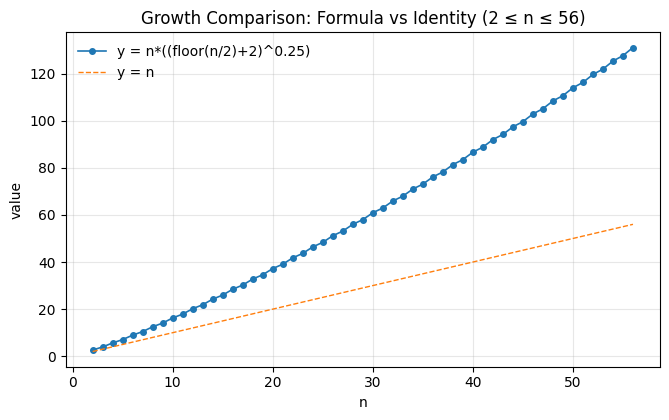

Formula value range: [2.6321, 131.0594] over 55 n-values


In [1]:
# Section 24: Visualize Formula y = n * ((floor(n/2) + 2) ** 0.25) over domain n=2..56 with y = n reference line
# Uses matplotlib already imported earlier as pyplot

import matplotlib.pyplot as pyplot  # already imported earlier; safe re-import
import pandas  # already imported earlier; safe re-import

startN = 2
endNExclusive = 57  # so last n is 56

# Define formula clearly

def computeParityAdjustedGrowth(nValue: int) -> float:
    halfRoundedDown = nValue // 2
    yValue = nValue * ((halfRoundedDown + 2) ** 0.25)
    return float(yValue)

listNValues: list[int] = list(range(startN, endNExclusive))
listYValues: list[float] = [computeParityAdjustedGrowth(nValue) for nValue in listNValues]
listIdentity: list[int] = listNValues  # y = n reference

# Tabular preview (first 10 rows)
dataframePreview = pandas.DataFrame({
    'n': listNValues,
    'yFormula': listYValues,
    'yIdentity': listIdentity
})
print(dataframePreview.head(10).to_string(index=False))

# Simple line plot with reference
pyplot.figure(figsize=(6.8, 4.3))
pyplot.plot(listNValues, listYValues, marker='o', markersize=4, linewidth=1.2, color='tab:blue', label='y = n*((floor(n/2)+2)^0.25)')
pyplot.plot(listNValues, listIdentity, linestyle='--', linewidth=1.0, color='tab:orange', label='y = n')
pyplot.xlabel('n')
pyplot.ylabel('value')
pyplot.title('Growth Comparison: Formula vs Identity (2 ≤ n ≤ 56)')
pyplot.legend(frameon=False)
pyplot.grid(True, alpha=0.3)
pyplot.tight_layout()
pyplot.show()

yFormulaMin = min(listYValues)
yFormulaMax = max(listYValues)
print(f'Formula value range: [{yFormulaMin:.4f}, {yFormulaMax:.4f}] over {len(listNValues)} n-values')